# PyroSense: Wildfire Prediction with Foundation Models

This notebook demonstrates the full PyroSense pipeline:
1. **Data Loading**: Fire events from Mesogeos datacube
2. **HLS Imagery**: Satellite composites from NASA Earthdata
3. **Multi-Source Features**: Prithvi (1024-dim), Weather (10-dim), AlphaEarth (64-dim)
4. **Stacking Ensemble**: Two-level architecture with source-specific base models

## Architecture

```
┌─────────────────┐    ┌─────────────────┐    ┌─────────────────┐
│  HLS Satellite  │    │  Weather Data   │    │   AlphaEarth    │
│    Imagery      │    │  (Open-Meteo)   │    │ (Earth Engine)  │
└────────┬────────┘    └────────┬────────┘    └────────┬────────┘
         │                      │                      │
         ▼                      ▼                      ▼
┌─────────────────┐    ┌─────────────────┐    ┌─────────────────┐
│    Prithvi      │    │    Weather      │    │   AlphaEarth    │
│   Extractor     │    │   Extractor     │    │   Extractor     │
│  (1024 dims)    │    │   (10 dims)     │    │   (64 dims)     │
└────────┬────────┘    └────────┬────────┘    └────────┬────────┘
         │                      │                      │
         ▼                      ▼                      ▼
┌─────────────────┐    ┌─────────────────┐    ┌─────────────────┐
│  Base Model 1   │    │  Base Model 2   │    │  Base Model 3   │
│  (RandomForest) │    │  (RandomForest) │    │  (RandomForest) │
└────────┬────────┘    └────────┬────────┘    └────────┬────────┘
         │                      │                      │
         └──────────────────────┼──────────────────────┘
                                │
                                ▼
                    ┌─────────────────────┐
                    │    Meta-Learner     │
                    │ (LogisticRegression)│
                    └──────────┬──────────┘
                               │
                               ▼
                    ┌─────────────────────┐
                    │   Fire Prediction   │
                    │   P(fire | event)   │
                    └─────────────────────┘
```

## 1. Setup

In [1]:
from pathlib import Path
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress verbose logging and warnings
from loguru import logger
logger.disable("pyrosense")  # Disable pyrosense logs in notebook
warnings.filterwarnings("ignore", category=RuntimeWarning)  # Suppress sklearn warnings

# PyroSense imports
from pyrosense.data.mesogeos_loader import MesogeosLoader, save_events_csv, load_events_csv
from pyrosense.data.hls_downloader import HLSDownloader
from pyrosense.features.prithvi import PrithviExtractor
from pyrosense.features.weather import WeatherExtractor
from pyrosense.features.store import FeatureStore
from pyrosense.models.stacking import StackingEnsemble, StackingConfig

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

# Paths
DATA_DIR = Path("../data")
MESOGEOS_PATH = DATA_DIR / "mesogeos/mesogeos.zarr"
HLS_DIR = DATA_DIR / "hls"
FEATURE_STORE_DIR = DATA_DIR / "features"
EVENTS_CACHE = DATA_DIR / "fire_events.csv"

print(f"Data directory: {DATA_DIR.resolve()}")

Data directory: /Users/georgepapakonstantinou/Documents/hackathon/data


## 2. Load Fire Events from Mesogeos

Mesogeos is used **only** for fire labels (where/when fires occurred).
The predictive features come from Prithvi, Weather, and AlphaEarth.

In [2]:
# Load or extract fire events
if EVENTS_CACHE.exists():
    all_events = load_events_csv(str(EVENTS_CACHE))
    fire_events = [e for e in all_events if e.burned_area > 0]
    negative_events = [e for e in all_events if e.burned_area == 0]
    print(f"Loaded from cache: {len(fire_events)} fire + {len(negative_events)} no-fire")
else:
    loader = MesogeosLoader(str(MESOGEOS_PATH), region="greece")
    fire_events = loader.extract_fire_events(
        n_samples=100, min_burned_area=0.0,
        start_year=2015, end_year=2021, random_seed=42,
    )
    # Sample negative events from DIFFERENT locations (no spatial leakage)
    negative_events = loader.sample_negative_events_different_locations(
        n_samples=100,
        fire_events=fire_events,
        min_distance_deg=0.1,  # ~10km minimum from any fire
        random_seed=42,
    )
    all_events = fire_events + negative_events
    save_events_csv(all_events, str(EVENTS_CACHE))
    print(f"Extracted: {len(fire_events)} fire + {len(negative_events)} no-fire")

all_events = fire_events + negative_events
print(f"Total events: {len(all_events)}")

# Create labels
labels = {e.event_id: 1.0 if e.burned_area > 0 else 0.0 for e in all_events}
y = np.array([labels[e.event_id] for e in all_events])

Loaded from cache: 100 fire + 100 no-fire
Total events: 200


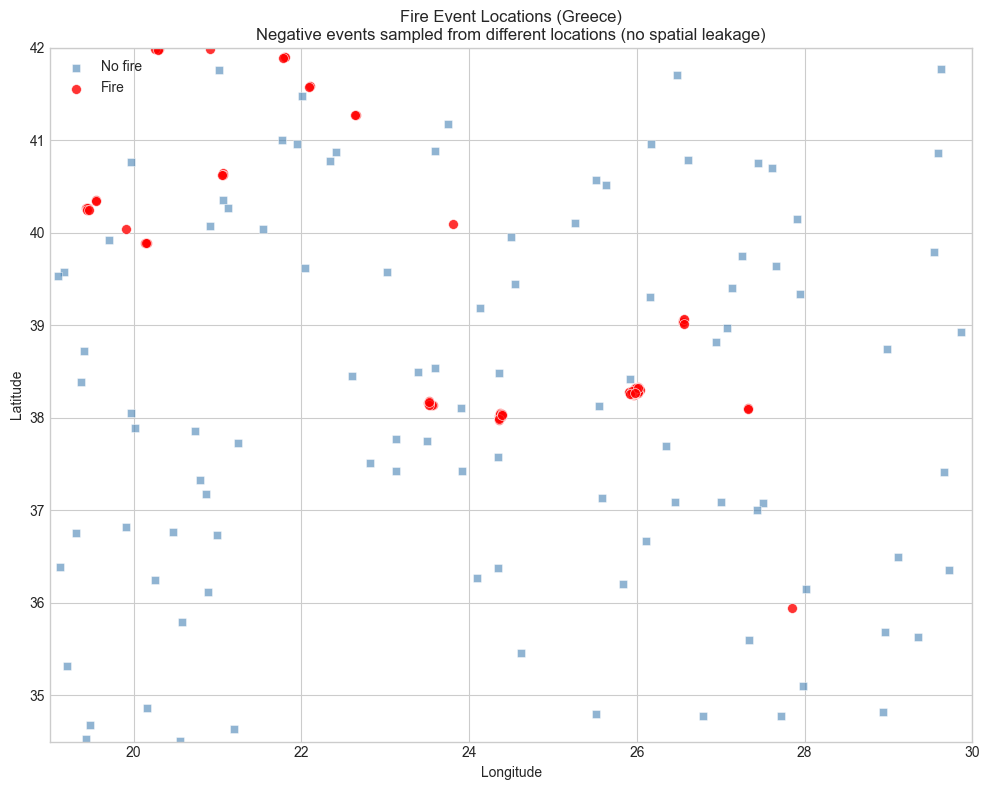

In [3]:
# Visualize fire event locations
fig, ax = plt.subplots(figsize=(10, 8))

fire_lats = [e.latitude for e in fire_events]
fire_lons = [e.longitude for e in fire_events]
neg_lats = [e.latitude for e in negative_events]
neg_lons = [e.longitude for e in negative_events]

# No jitter needed - locations are now different
ax.scatter(neg_lons, neg_lats, c='steelblue', alpha=0.6, s=40, 
           marker='s', label='No fire', edgecolors='white', linewidth=0.5)
ax.scatter(fire_lons, fire_lats, c='red', alpha=0.8, s=50, 
           marker='o', label='Fire', edgecolors='white', linewidth=0.5)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Fire Event Locations (Greece)\nNegative events sampled from different locations (no spatial leakage)')
ax.legend()
ax.set_xlim(19, 30)
ax.set_ylim(34.5, 42)
plt.tight_layout()
plt.show()

## 3. Download HLS Satellite Imagery

For each event, we download a 6-band HLS composite from NASA Earthdata.
The 6 bands (Blue, Green, Red, NIR, SWIR1, SWIR2) are what Prithvi expects.

In [4]:
# Skip downloading - just use what's already on disk
SKIP_HLS_DOWNLOAD = True  # Set to False to download missing images

downloader = HLSDownloader(
    output_dir=str(HLS_DIR),
    days_before=30,
    min_days_before=7,
)

if SKIP_HLS_DOWNLOAD:
    print("Skipping HLS download - using cached composites only")
    composites = downloader.get_available_composites()
    print(f"Found {len(composites)} cached HLS composites")
    
    # Count how many events have imagery
    fire_with_hls = sum(1 for e in fire_events if e.event_id in composites)
    nofire_with_hls = sum(1 for e in negative_events if e.event_id in composites)
    print(f"  Fire events with HLS: {fire_with_hls}/{len(fire_events)}")
    print(f"  No-fire events with HLS: {nofire_with_hls}/{len(negative_events)}")
else:
    print("Downloading HLS imagery (7-30 days BEFORE each event)")
    print("=" * 60)
    successes, failures = downloader.download_for_events(all_events)
    print(f"\nDownload complete: {len(successes)}/{len(all_events)} succeeded")
    composites = downloader.get_available_composites()

print(f"\nTotal available composites: {len(composites)}")

Skipping HLS download - using cached composites only
Found 170 cached HLS composites
  Fire events with HLS: 98/100
  No-fire events with HLS: 72/100

Total available composites: 170


## 4. Feature Extraction with FeatureStore

We extract features from multiple sources and store them using the project's FeatureStore.

In [5]:
# Initialize the feature store
store = FeatureStore(str(FEATURE_STORE_DIR))

print(f"Feature store: {FEATURE_STORE_DIR}")
print(f"Existing sources: {store.list_sources()}")

Feature store: ../data/features
Existing sources: ['prithvi', 'weather', 'alphaearth']


### 4.1 Prithvi Features (1024-dim)

Extract features from frozen Prithvi-EO-2.0-300M encoder.

In [6]:
if store.exists("prithvi"):
    prithvi_df = store.load("prithvi")
    print(f"Loaded Prithvi features from store: {prithvi_df.shape}")
else:
    print("Extracting Prithvi features...")
    prithvi_extractor = PrithviExtractor(model_name="Prithvi-EO-2.0-300M", device="auto")
    print(f"Device: {prithvi_extractor.device}")
    
    # Get available composites
    composites = downloader.get_available_composites()
    print(f"Found {len(composites)} HLS composites")
    
    # Build image paths for events with available composites
    image_paths = []
    events_with_images = []
    for event in all_events:
        composite = composites.get(event.event_id)
        if composite and composite.exists():
            image_paths.append(composite)
            events_with_images.append(event)
    
    print(f"Events with HLS imagery: {len(events_with_images)}/{len(all_events)}")
    
    # Extract features (returns DataFrame with prithvi_ prefix already)
    prithvi_df = prithvi_extractor.extract_batch(events_with_images, image_paths=image_paths)
    
    # Save to store
    store.save("prithvi", prithvi_df)
    print(f"Extracted and saved: {prithvi_df.shape}")

print(f"Prithvi features: {prithvi_df.shape[1]} dimensions")

Loaded Prithvi features from store: (170, 1024)
Prithvi features: 1024 dimensions


### 4.2 Weather Features (10-dim)

Extract 7-day pre-event weather from Open-Meteo API.

In [7]:
if store.exists("weather"):
    weather_df = store.load("weather")
    print(f"Loaded Weather features from store: {weather_df.shape}")
else:
    print("Extracting Weather features...")
    weather_extractor = WeatherExtractor(days_before=7)
    
    # extract_batch returns DataFrame with weather_ prefix already
    weather_df = weather_extractor.extract_batch(all_events)
    
    # Save to store
    store.save("weather", weather_df)
    print(f"Extracted and saved: {weather_df.shape}")

print(f"Weather features: {weather_df.shape[1]} dimensions")
print(f"Feature names: {list(weather_df.columns)}")

Loaded Weather features from store: (200, 10)
Weather features: 10 dimensions
Feature names: ['weather_temp_max', 'weather_temp_min', 'weather_temp_mean', 'weather_humidity_max', 'weather_humidity_min', 'weather_humidity_mean', 'weather_wind_max', 'weather_wind_mean', 'weather_precip_sum', 'weather_precip_max']


### 4.3 AlphaEarth Features (64-dim) - Optional

Extract land surface embeddings from Google Earth Engine.

**Note:** Requires Earth Engine authentication. Skip if not configured.

In [ ]:
import os

# AlphaEarth - requires Earth Engine authentication
USE_ALPHAEARTH = True

# Set your GCP project ID here or via environment variable GOOGLE_CLOUD_PROJECT
GCP_PROJECT = os.environ.get("GOOGLE_CLOUD_PROJECT", None) or "your-project-id"

if USE_ALPHAEARTH:
    if not GCP_PROJECT:
        print("AlphaEarth requires a GCP project ID.")
        print("   Set via: export GOOGLE_CLOUD_PROJECT=your-project-id")
        print("   Skipping AlphaEarth features...")
        alphaearth_df = None
    else:
        from pyrosense.features.alphaearth import AlphaEarthExtractor
        
        if store.exists("alphaearth"):
            alphaearth_df = store.load("alphaearth")
            print(f"Loaded AlphaEarth features from store: {alphaearth_df.shape}")
        else:
            print(f"Extracting AlphaEarth features (project: {GCP_PROJECT})...")
            alphaearth_extractor = AlphaEarthExtractor(
                cache_dir=str(DATA_DIR / "alphaearth"),
                project=GCP_PROJECT
            )
            
            # extract_batch returns DataFrame with alphaearth_ prefix already
            alphaearth_df = alphaearth_extractor.extract_batch(all_events)
            
            store.save("alphaearth", alphaearth_df)
            print(f"Extracted and saved: {alphaearth_df.shape}")
        
        print(f"AlphaEarth features: {alphaearth_df.shape[1]} dimensions")
else:
    print("AlphaEarth disabled.")
    alphaearth_df = None

### 4.4 Combine Features

Merge all feature sources into a single DataFrame.

In [9]:
# Combine available features
sources = ["prithvi", "weather"]
if alphaearth_df is not None:
    sources.append("alphaearth")

X_combined = store.get_combined(sources)

# Get events that have all features (primarily limited by Prithvi/HLS availability)
available_events = [e for e in all_events if e.event_id in X_combined.index]
print(f"Events with all features: {len(available_events)}/{len(all_events)}")

# Align with available events
event_ids = [e.event_id for e in available_events]
X_combined = X_combined.reindex(event_ids)

# Update labels for available events
y_aligned = np.array([labels[eid] for eid in X_combined.index])

print(f"Combined features shape: {X_combined.shape}")
print(f"Sources: {sources}")
print(f"\nFeature breakdown:")
for source in sources:
    cols = [c for c in X_combined.columns if c.startswith(f"{source}_")]
    print(f"  {source}: {len(cols)} dimensions")
    
print(f"\nClass balance: {y_aligned.mean():.1%} fire, {1-y_aligned.mean():.1%} no-fire")

Events with all features: 170/200
Combined features shape: (170, 1098)
Sources: ['prithvi', 'weather', 'alphaearth']

Feature breakdown:
  prithvi: 1024 dimensions
  weather: 10 dimensions
  alphaearth: 64 dimensions

Class balance: 57.6% fire, 42.4% no-fire


## 5. Train Stacking Ensemble

The stacking ensemble uses:
- **Level 1 (Base models)**: One RandomForest per feature source
- **Level 2 (Meta-learner)**: LogisticRegression on base model predictions

This allows each source to be modeled independently, then combined optimally.

In [10]:
from sklearn.model_selection import train_test_split

# y_aligned is already created in the previous cell

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_aligned, test_size=0.2, random_state=42, stratify=y_aligned
)

print(f"Train: {X_train.shape[0]} samples")
print(f"Test:  {X_test.shape[0]} samples")
print(f"Class balance (train): {y_train.mean():.1%} fire")

Train: 136 samples
Test:  34 samples
Class balance (train): 57.4% fire


In [11]:
# Configure stacking ensemble
config = StackingConfig.simple(sources=sources)

print("Stacking Configuration:")
print(f"  CV folds: {config.cv_folds}")
print(f"  Use probabilities: {config.use_probabilities}")
print(f"\nFeature groups:")
for group in config.feature_groups:
    print(f"  - {group.name}: prefix='{group.column_prefix}'")

Stacking Configuration:
  CV folds: 5
  Use probabilities: True

Feature groups:
  - prithvi: prefix='prithvi_'
  - weather: prefix='weather_'
  - alphaearth: prefix='alphaearth_'


In [12]:
# Train the stacking ensemble
ensemble = StackingEnsemble(config)

print("Training stacking ensemble...")
ensemble.fit(X_train, y_train)

print("\nTraining complete!")
print(ensemble.summary())

Training stacking ensemble...

Training complete!
{'n_feature_groups': 3, 'feature_groups': ['prithvi', 'weather', 'alphaearth'], 'features_per_group': {'prithvi': 1024, 'weather': 10, 'alphaearth': 64}, 'meta_model': 'LogisticRegression', 'source_weights': {'prithvi': 2.3096522410165794, 'weather': 3.2788112663800644, 'alphaearth': 1.102164119234673}, 'config': {'cv_folds': 5, 'use_probabilities': True, 'scale_features': True}}


## 6. Evaluation

In [13]:
from sklearn.metrics import (
    roc_auc_score, roc_curve, accuracy_score, 
    precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# Predictions
y_prob = ensemble.predict_proba(X_test)[:, 1]
y_pred = ensemble.predict(X_test)

# Metrics
print("=" * 50)
print("STACKING ENSEMBLE - Test Set Metrics")
print("=" * 50)
print(f"  AUC:       {roc_auc_score(y_test, y_prob):.4f}")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"  F1:        {f1_score(y_test, y_pred, zero_division=0):.4f}")

STACKING ENSEMBLE - Test Set Metrics
  AUC:       0.9714
  Accuracy:  0.8824
  Precision: 0.9444
  Recall:    0.8500
  F1:        0.8947


In [14]:
# Source contribution weights
weights = ensemble.source_weights()

print("\nSource Contribution Weights:")
for source, weight in sorted(weights.items(), key=lambda x: -x[1]):
    bar = "█" * int(weight * 40)
    print(f"  {source:12s}: {weight:.3f} {bar}")


Source Contribution Weights:
  weather     : 3.279 ███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
  prithvi     : 2.310 ████████████████████████████████████████████████████████████████████████████████████████████
  alphaearth  : 1.102 ████████████████████████████████████████████


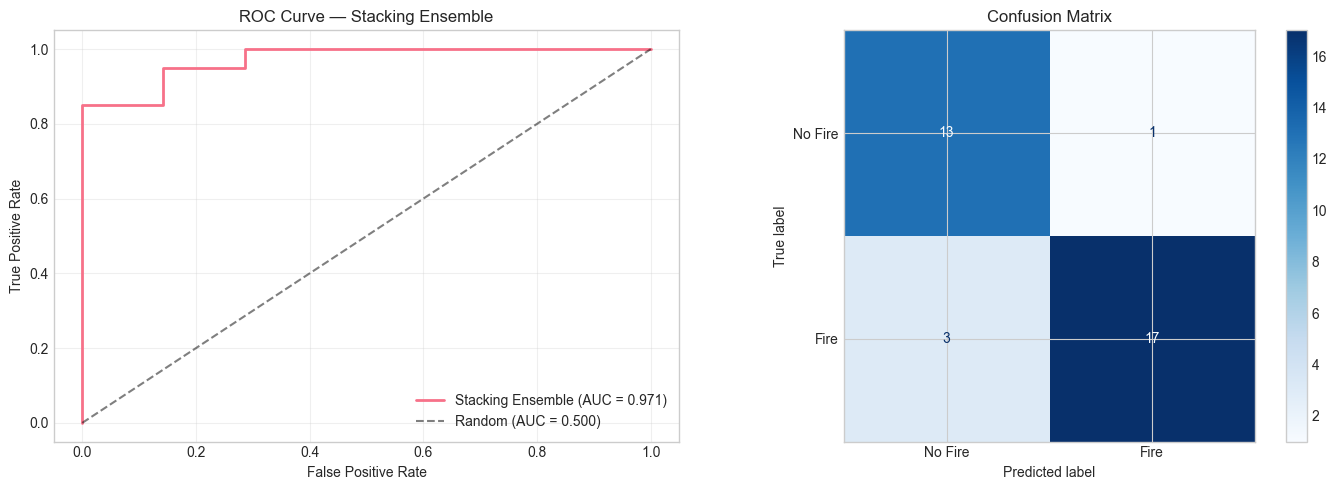

In [15]:
# ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC
ax = axes[0]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_val = roc_auc_score(y_test, y_prob)

ax.plot(fpr, tpr, linewidth=2, label=f'Stacking Ensemble (AUC = {auc_val:.3f})')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random (AUC = 0.500)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve — Stacking Ensemble')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# Confusion Matrix
ax = axes[1]
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Fire', 'Fire'])
disp.plot(ax=ax, cmap='Blues')
ax.set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

## 7. Cross-Validation

In [16]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score

# Re-train on full data for CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a fresh ensemble for CV
cv_ensemble = StackingEnsemble(config)

# Use custom scorer to ensure predict_proba is used correctly
def auc_scorer(estimator, X, y):
    y_prob = estimator.predict_proba(X)[:, 1]
    return roc_auc_score(y, y_prob)

cv_scores = cross_val_score(
    cv_ensemble, X_combined, y_aligned, 
    cv=cv, scoring=auc_scorer
)

print(f"5-Fold CV AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"  Per fold: {[f'{s:.3f}' for s in cv_scores]}")

5-Fold CV AUC: 0.9837 ± 0.0096
  Per fold: ['0.989', '1.000', '0.975', '0.979', '0.975']


## 8. Comparison: Stacking vs Single Source

Compare the stacking ensemble against using only one feature source.

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

results = []

# Test each source individually
for source in sources:
    # Get columns for this source
    cols = [c for c in X_combined.columns if c.startswith(f"{source}_")]
    X_source = X_combined[cols]
    
    # Scale and clean
    X_clean = np.nan_to_num(X_source.values, nan=0.0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)
    
    # CV
    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    scores = cross_val_score(clf, X_scaled, y_aligned, cv=cv, scoring="roc_auc")
    
    results.append({
        "Model": f"{source.capitalize()} only",
        "Features": len(cols),
        "CV AUC": scores.mean(),
        "Std": scores.std()
    })

# Add stacking result
results.append({
    "Model": "Stacking Ensemble",
    "Features": X_combined.shape[1],
    "CV AUC": cv_scores.mean(),
    "Std": cv_scores.std()
})

# Display results
results_df = pd.DataFrame(results).sort_values("CV AUC", ascending=False)
print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(results_df.to_string(index=False))
print("=" * 60)


MODEL COMPARISON
            Model  Features   CV AUC      Std
Stacking Ensemble      1098 0.983734 0.009627
     Weather only        10 0.974198 0.012798
     Prithvi only      1024 0.950144 0.028554
  Alphaearth only        64 0.783083 0.024414


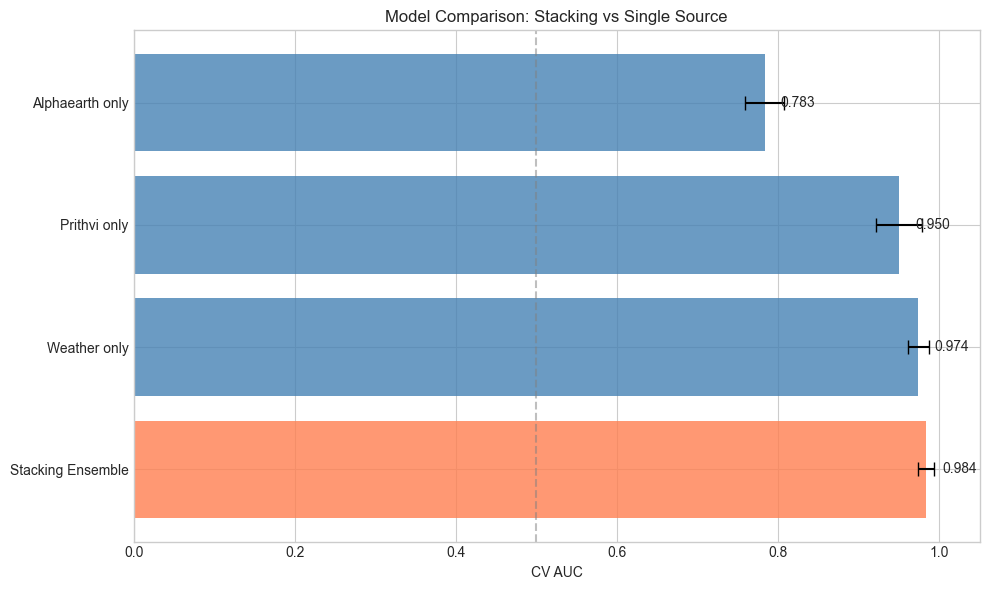

In [18]:
# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Color the Stacking Ensemble differently (it's always the last row before sorting)
# After sorting, we need to identify it by name
colors = ['coral' if 'Stacking' in model else 'steelblue' for model in results_df["Model"]]

bars = ax.barh(results_df["Model"], results_df["CV AUC"], color=colors, alpha=0.8)
ax.errorbar(
    results_df["CV AUC"], results_df["Model"], 
    xerr=results_df["Std"], fmt='none', color='black', capsize=5
)

ax.set_xlabel('CV AUC')
ax.set_title('Model Comparison: Stacking vs Single Source')
ax.set_xlim(0, 1.05)
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Random baseline')

# Add value labels
for bar, val in zip(bars, results_df["CV AUC"]):
    ax.text(val + 0.02, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
            va='center', fontsize=10)

plt.tight_layout()
plt.show()

## 9. Save Model

In [19]:
import joblib

MODEL_PATH = DATA_DIR / "stacking_ensemble.pkl"

# Retrain on full data
final_ensemble = StackingEnsemble(config)
final_ensemble.fit(X_combined, y_aligned)

# Save
joblib.dump(final_ensemble, MODEL_PATH)
print(f"Model saved to: {MODEL_PATH}")

# Verify
loaded = joblib.load(MODEL_PATH)
test_pred = loaded.predict_proba(X_test)[:, 1]
print(f"Verification AUC: {roc_auc_score(y_test, test_pred):.4f}")

Model saved to: ../data/stacking_ensemble.pkl
Verification AUC: 1.0000


## Summary

This notebook demonstrated the full PyroSense pipeline:

1. **Data**: Loaded fire events from Mesogeos datacube
2. **Features**: Extracted multi-source features:
   - Prithvi (1024-dim): Satellite imagery embeddings
   - Weather (10-dim): 7-day pre-event conditions
   - AlphaEarth (64-dim): Land surface embeddings (optional)
3. **Model**: Trained stacking ensemble with source-specific base models
4. **Evaluation**: Compared against single-source baselines
5. **VLM Analysis**: EarthDial for interactive fire area Q&A (optional)

### Next Steps

- Enable AlphaEarth features for improved predictions
- Increase dataset size (more fire events)
- Test on different geographic regions
- Use EarthDial for detailed fire risk reports
- Deploy with CLI:
  - `pyrosense predict --model stacking_ensemble.pkl --lat 38.5 --lon 23.1 --date 2024-07-15`
  - `pyrosense analyze --image data/hls/fire_0001/composite.tif`
  - `pyrosense chat --image data/hls/fire_0001/composite.tif`

## 10. EarthDial VLM Analysis (Optional)

Use EarthDial Vision-Language Model to interactively analyze high-risk areas.

**Requirements:**
- Install: `pip install pyrosense[earthdial]`
- ~8GB VRAM/RAM for float16 model
- First run downloads ~8GB model from HuggingFace

Analyzing highest-risk area:
  Event: fire_0081
  Location: (39.0701, 26.5663)
  Fire probability: 93.9%


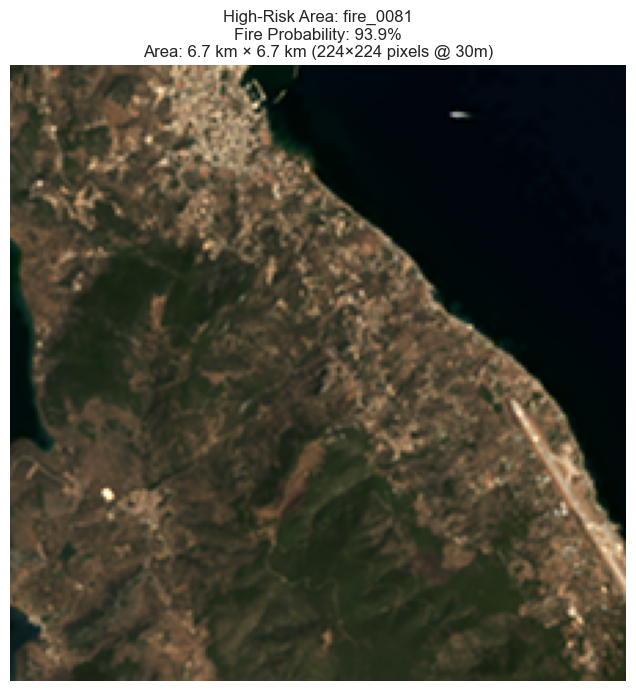


Loading EarthDial model...
Generating fire risk report...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


EARTHDIAL FIRE RISK REPORT

SUMMARY:
There is a high fire risk in this area, as there is a large amount of vegetation and a mountainous terrain.

VEGETATION:
The vegetation visible in this satellite image is a mix of different types, including transitional vegetation, natural grassland, and water bodies. The transitional vegetation is located at the bottom of the image, while the natural grassland is present in the center and the water bodies are located at the top and bottom left. The vegetation appears to be in a natural state, with no signs of human intervention. The water bodies are likely lakes or rivers, and the transitional vegetation is likely a mix of different plant species that are adapted to the local environment.

TERRAIN:
The terrain in this satellite image appears to be a mix of mountainous and flat regions. The mountainous region is located at the center of the image, while the flat region is situated at the bottom left. The mountainous region has a rugged appearance w

In [20]:
# Optional: EarthDial analysis of high-risk areas
# Requires: pip install pyrosense[earthdial]

ENABLE_EARTHDIAL = True  # Set to True to enable (requires ~8GB memory)

if ENABLE_EARTHDIAL:
    try:
        import warnings
        warnings.filterwarnings("ignore")  # Suppress all warnings for cleaner output
        
        from pyrosense.vlm import EarthDialAssistant, hls_to_rgb
        
        # Find highest risk prediction from test set
        high_risk_idx = y_prob.argmax()
        high_risk_event_id = X_test.index[high_risk_idx]
        high_risk_event = next(e for e in available_events if e.event_id == high_risk_event_id)
        high_risk_prob = y_prob[high_risk_idx]
        
        print(f"Analyzing highest-risk area:")
        print(f"  Event: {high_risk_event.event_id}")
        print(f"  Location: ({high_risk_event.latitude:.4f}, {high_risk_event.longitude:.4f})")
        print(f"  Fire probability: {high_risk_prob:.1%}")
        
        # Get HLS image path
        image_path = HLS_DIR / high_risk_event.event_id / "composite.tif"
        
        if image_path.exists():
            # Convert to RGB with cropping centered on event location
            # Crops to 224x224 pixels (6.7 km x 6.7 km) - same area used by Prithvi
            rgb_path = hls_to_rgb(
                image_path,
                center_lat=high_risk_event.latitude,
                center_lon=high_risk_event.longitude,
                crop_size=224
            )
            
            # Display the CROPPED image (same area as fire probability prediction)
            from PIL import Image
            img = Image.open(rgb_path)
            plt.figure(figsize=(8, 8))
            plt.imshow(img)
            plt.title(f"High-Risk Area: {high_risk_event.event_id}\n"
                     f"Fire Probability: {high_risk_prob:.1%}\n"
                     f"Area: 6.7 km × 6.7 km (224×224 pixels @ 30m)")
            plt.axis('off')
            plt.show()
            
            # Load EarthDial and analyze
            print("\nLoading EarthDial model...")
            assistant = EarthDialAssistant(device="auto")
            
            # Generate report (uses event coordinates for consistent cropping)
            print("Generating fire risk report...")
            report = assistant.generate_report(
                image_path,
                event=high_risk_event,
                fire_probability=high_risk_prob
            )
            
            print("\n" + "=" * 60)
            print("EARTHDIAL FIRE RISK REPORT")
            print("=" * 60)
            print(f"\nSUMMARY:\n{report['summary']}")
            print(f"\nVEGETATION:\n{report['vegetation_analysis']}")
            print(f"\nTERRAIN:\n{report['terrain_factors']}")
            print(f"\nSTRATEGIES:\n{report['recommended_strategies']}")
            print(f"\nRISK ASSESSMENT:\n{report['risk_assessment']}")
            print("=" * 60)
        else:
            print(f"HLS image not found: {image_path}")
            
    except ImportError:
        print("EarthDial not installed.")
        print("Install with: pip install pyrosense[earthdial]")
    except Exception as e:
        import traceback
        print(f"EarthDial error: {e}")
        traceback.print_exc()
else:
    print("EarthDial analysis disabled. Set ENABLE_EARTHDIAL = True to enable.")